### Clelia Caetano 2023060 (CA2_SEM2)
### MSc. in Data Analytics
### Project Tweets

In [1]:
# sc master - running locally
sc.master

'local[*]'

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load the libraries
import os
from pyspark.sql import SparkSession

### Initialize Spark Session

In [4]:
# Create a Spark session with necessary configurations
spark = SparkSession.builder.appName('ProjectTweets') \
                    .config("spark.some_config_option", "config_value") \
                    .getOrCreate()

### Read the Data from HDFS

In [5]:
# Load the data and create a temporary view in Spark
try:
    # Read the data.csv into Hadoop from HDFS (Hadoop Distributed File System) storage
    data = spark.read.option("header", "true").csv("hdfs://localhost:9000/user/hduser/CA2/ProjectTweets.csv")
    
    # Check if the data was loaded successfully
    if data is not None:
        # Define column names
        new_column_names = ["number", "id_tweet", "date", "query", "user_id", "tweet"]

        # Use the alias method to rename the columns
        for i in range(len(new_column_names)):
            data = data.withColumnRenamed(data.columns[i], new_column_names[i])

        # Create a temporary table from the DataFrame
        data.createOrReplaceTempView("CA2_ProjectTweets")

        # Run Spark SQL queries using the same SparkSession
        data = spark.sql("SELECT * FROM CA2_ProjectTweets") 

        # Display the first 5 rows
        data.show(5)
    else:
        print("Data not loaded successfully.")

except Exception as e:
    print("An error occurred:", str(e))

+------+----------+--------------------+--------+-------------+--------------------+
|number|  id_tweet|                date|   query|      user_id|               tweet|
+------+----------+--------------------+--------+-------------+--------------------+
|     1|1467810672|Mon Apr 06 22:19:...|NO_QUERY|scotthamilton|is upset that he ...|
|     2|1467810917|Mon Apr 06 22:19:...|NO_QUERY|     mattycus|@Kenichan I dived...|
|     3|1467811184|Mon Apr 06 22:19:...|NO_QUERY|      ElleCTF|my whole body fee...|
|     4|1467811193|Mon Apr 06 22:19:...|NO_QUERY|       Karoli|@nationwideclass ...|
|     5|1467811372|Mon Apr 06 22:20:...|NO_QUERY|     joy_wolf|@Kwesidei not the...|
+------+----------+--------------------+--------+-------------+--------------------+
only showing top 5 rows



### Create a Hive database in Spark application

In [6]:
# Save the DataFrame as a Hive table
data.write.mode("overwrite").saveAsTable("ca2_projecttweets")

2023-11-08 12:35:37,182 WARN conf.HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
2023-11-08 12:35:37,182 WARN conf.HiveConf: HiveConf of name hive.stats.retries.wait does not exist
2023-11-08 12:35:41,751 WARN metastore.ObjectStore: Version information not found in metastore. hive.metastore.schema.verification is not enabled so recording the schema version 2.3.0
2023-11-08 12:35:41,752 WARN metastore.ObjectStore: setMetaStoreSchemaVersion called but recording version is disabled: version = 2.3.0, comment = Set by MetaStore hduser@127.0.1.1
2023-11-08 12:35:42,833 WARN metastore.ObjectStore: Failed to get database global_temp, returning NoSuchObjectException
2023-11-08 12:35:56,861 WARN session.SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.
2023-11-08 12:35:57,044 WARN conf.HiveConf: HiveConf of name hive.internal.ss.authz.settings.applied.marker does not exist
2023-11-08 12:3

In [7]:
# Set the current database
spark.sql("USE ca2_projecttweets")

DataFrame[]

In [8]:
# Run a SQL query to select all rows from the table
result = spark.sql("SELECT `number`, `id_tweet`, `date`, `query`, `user_id`, `tweet` FROM ca2_projecttweets")

# Show the first 5 rows
result.show(5)

+------+----------+--------------------+--------+-------------+--------------------+
|number|  id_tweet|                date|   query|      user_id|               tweet|
+------+----------+--------------------+--------+-------------+--------------------+
|     1|1467810672|Mon Apr 06 22:19:...|NO_QUERY|scotthamilton|is upset that he ...|
|     2|1467810917|Mon Apr 06 22:19:...|NO_QUERY|     mattycus|@Kenichan I dived...|
|     3|1467811184|Mon Apr 06 22:19:...|NO_QUERY|      ElleCTF|my whole body fee...|
|     4|1467811193|Mon Apr 06 22:19:...|NO_QUERY|       Karoli|@nationwideclass ...|
|     5|1467811372|Mon Apr 06 22:20:...|NO_QUERY|     joy_wolf|@Kwesidei not the...|
+------+----------+--------------------+--------+-------------+--------------------+
only showing top 5 rows



In [9]:
# Save the preprocessed data as a new table if needed
result.write.mode("overwrite").saveAsTable("preprocessed_ca2_projecttweets")

In [10]:
# Access the Hive table and create a DataFrame
data = spark.table("preprocessed_ca2_projecttweets")

# Print the schema
data.printSchema()

root
 |-- number: string (nullable = true)
 |-- id_tweet: string (nullable = true)
 |-- date: string (nullable = true)
 |-- query: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- tweet: string (nullable = true)



In [11]:
# Check the size of the data
data_size = data.count()
print(f"The size of the dataset is: {data_size} rows")

The size of the dataset is: 1599999 rows


### Exploratory data analysis (EDA)

In [12]:
# Calculate the number of unique values in each column.
# List of column names
column_names = ["number", "id_tweet", "date", "query", "user_id", "tweet"]

# Dictionary to store unique value counts
unique_counts = {}

# Iterate through the columns and count unique values
for column_name in column_names:
    unique_values = data.select(column_name).distinct()
    unique_count = unique_values.count()
    unique_counts[column_name] = unique_count

# Print the overall count for each column
print("Overall unique value counts:")
for column, count in unique_counts.items():
    print(f"{column}: {count}")

Overall unique value counts:
number: 1599999
id_tweet: 1598314
date: 774362
query: 1
user_id: 659775
tweet: 1581465


In [13]:
# Drop columns that are duplicates and other irrelevant data information
data = data.drop('number', 'id_tweet', 'query', 'user_id')

# Show the updated DataFrame
data.show(5)

+--------------------+--------------------+
|                date|               tweet|
+--------------------+--------------------+
|Mon Apr 06 22:19:...|is upset that he ...|
|Mon Apr 06 22:19:...|@Kenichan I dived...|
|Mon Apr 06 22:19:...|my whole body fee...|
|Mon Apr 06 22:19:...|@nationwideclass ...|
|Mon Apr 06 22:20:...|@Kwesidei not the...|
+--------------------+--------------------+
only showing top 5 rows



### Missing Values

In [14]:
# Iterate through all columns and print missing value counts
for column_name in data.columns:
    missing_count = data.filter(data[column_name].isNull()).count()
    print(f"Missing values in '{column_name}': {missing_count}")

Missing values in 'date': 0
Missing values in 'tweet': 0


In [15]:
# Print the schema
data.printSchema()

root
 |-- date: string (nullable = true)
 |-- tweet: string (nullable = true)



In [16]:
# Call the columns
columns = ["date", "tweet"]

# Set 'tweet' column as the index to convert it as label
data = data.withColumn("label", data["tweet"])

### Descriptive Statistics

In [17]:
# Compute and interpret the mean, median, quartiles, and standard deviation for "date" and "tweet count"
data.describe(["date"]).show()

+-------+--------------------+
|summary|                date|
+-------+--------------------+
|  count|             1599999|
|   mean|                null|
| stddev|                null|
|    min|Fri Apr 17 20:30:...|
|    max|Wed May 27 07:27:...|
+-------+--------------------+



### Create a configuration to convert string 'date' into timestamp

In [23]:
# Config SparkSession from UTC to Pacific Day Time which is the same timezone as the original dataset
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
spark.conf.set("spark.sql.session.timeZone", "America/Los_Angeles")

# Import libraries to convert
from pyspark.sql.functions import from_unixtime, unix_timestamp
from pyspark.sql.types import TimestampType

# Convert 'date' column in string format to the timestamp
data = data.withColumn("date", from_unixtime(unix_timestamp(data["date"], "E MMM dd HH:mm:ss z yyyy")).cast(TimestampType()))

# Print the 'date' column with the new format
data.select("date").show(5)

+-------------------+
|               date|
+-------------------+
|2009-04-06 22:19:49|
|2009-04-06 22:19:53|
|2009-04-06 22:19:57|
|2009-04-06 22:19:57|
|2009-04-06 22:20:00|
+-------------------+
only showing top 5 rows



### Groupby 'date'

In [24]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import to_date, count
from pyspark.sql.window import Window

# Group the data by the date without the hour
data = data.withColumn("date_without_hour", to_date(data["date"]))
date_counts = data.groupBy("date_without_hour").agg(count("*").alias("tweet_count"))

# Sort the data by date without hour
date_counts = date_counts.orderBy("date_without_hour")

# Collect the data to the driver
date_counts = date_counts.collect()

# Extract dates and tweet counts for plotting
dates = [str(row.date_without_hour) for row in date_counts]
tweet_counts = [row.tweet_count for row in date_counts]

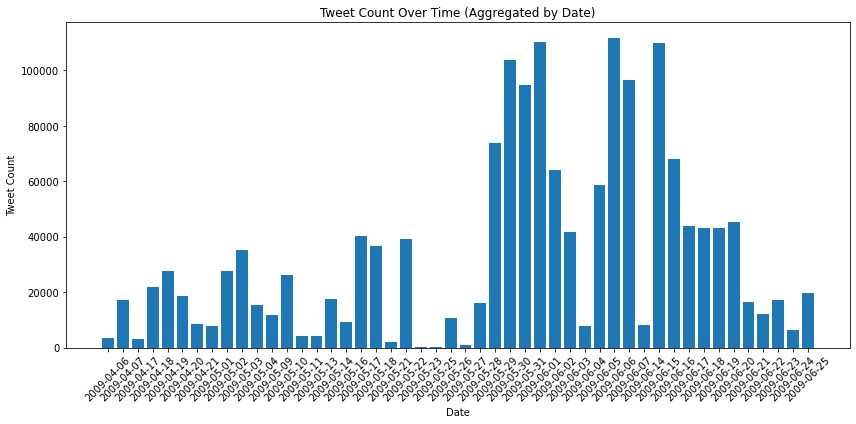

In [25]:
# Plot the tweet count
plt.figure(figsize=(12, 6))
plt.bar(dates, tweet_counts)
plt.title("Tweet Count Over Time (Aggregated by Date)")
plt.xlabel("Date")
plt.ylabel("Tweet Count")
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.tight_layout()

# Show the plot
plt.show()

In [26]:
from pyspark.sql.functions import col, date_add, datediff
import pyspark.sql.functions as F
from datetime import date, timedelta

# Extract the date part from the 'date' column
data = data.withColumn("date", col("date").cast("date"))

# Sort the DataFrame by date
data = data.orderBy("date")

# Calculate the next date using the lead function
data = data.withColumn("next_date", date_add(col("date"), 1))

# Check if the next date is continuous (no break)
data = data.withColumn("is_continuous", datediff(col("next_date"), col("date")) == 1)

# Create a window specification to order by date
window_spec = Window.orderBy("date")

# Assign a group identifier to continuous sequences
data = data.withColumn("group_id", F.sum(col("is_continuous").cast("int")).over(window_spec))

# Filter only the rows with continuous sequences
continuous_dates = data.filter(col("is_continuous")).select("date").distinct()

# Sort the list in ascending order
continuous_dates = continuous_dates.orderBy("date")

# Get the first and last dates in the DataFrame
first_date = continuous_dates.first().date
last_date = continuous_dates.orderBy(col("date").desc()).first().date

# Print the first and last dates
print("First Date:", first_date)
print("Last Date:", last_date)

# Define the start and end date for the range
start_date = first_date
end_date = last_date

# Generate a list of all dates in the range
date_range = [start_date + timedelta(days=x) for x in range((end_date - start_date).days + 1)]

# Convert the list of continuous dates to a Python list
continuous_dates_list = [row.date for row in continuous_dates.collect()]

# Find the dates not in the list
missing_dates = [d for d in date_range if d not in continuous_dates_list]

# Print the missing dates
for missing_date in missing_dates:
    print(missing_date)

# Count the missing days
missing_days_count = len(missing_dates)

# Print the missing days count
print("Missing Days Count:", missing_days_count)

First Date: 2009-04-06
Last Date: 2009-06-25


2009-04-08
2009-04-09
2009-04-10
2009-04-11
2009-04-12
2009-04-13
2009-04-14
2009-04-15
2009-04-16
2009-04-22
2009-04-23
2009-04-24
2009-04-25
2009-04-26
2009-04-27
2009-04-28
2009-04-29
2009-04-30
2009-05-05
2009-05-06
2009-05-07
2009-05-08
2009-05-12
2009-05-15
2009-05-19
2009-05-20
2009-05-24
2009-06-08
2009-06-09
2009-06-10
2009-06-11
2009-06-12
2009-06-13
Missing Days Count: 33


### Outliers

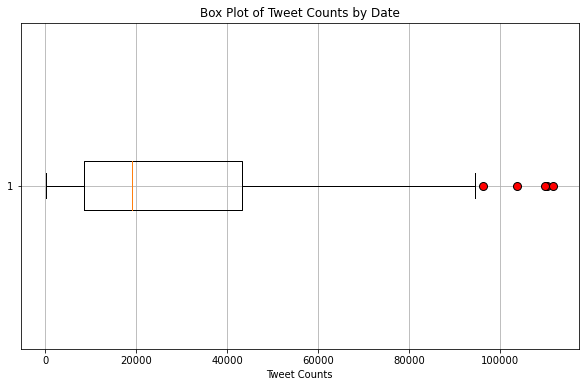

In [27]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import to_date, count
from pyspark.sql.window import Window

# Group the data by the date without the hour
data = data.withColumn("date_without_hour", to_date(data["date"]))
date_counts = data.groupBy("date_without_hour").agg(count("*").alias("tweet_count"))

# Sort the data by date without hour
date_counts = date_counts.orderBy("date_without_hour")

# Collect the data to the driver
date_counts = date_counts.collect()

# Extract tweet counts for plotting
tweet_counts = [row.tweet_count for row in date_counts]

# Create a box plot with outliers marked
plt.figure(figsize=(10, 6))
plt.boxplot(tweet_counts, vert=False, flierprops=dict(marker='o', markerfacecolor='red', markersize=8))
plt.title("Box Plot of Tweet Counts by Date")
plt.xlabel("Tweet Counts")
plt.grid(True)

plt.show()

In [28]:
# Display the potential outliers (if any) and print them
outliers = []

q1 = date_counts[0].tweet_count
q3 = date_counts[-1].tweet_count
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

for idx, tweet_count in enumerate(tweet_counts):
    if tweet_count < lower_bound or tweet_count > upper_bound:
        outliers.append((date_counts[idx].date_without_hour, tweet_count))

# Print the potential outliers
print("Potential Outliers:")
for date, count in outliers:
    print(f"Date: {date}, Tweet Count: {count}")

Potential Outliers:
Date: 2009-05-29, Tweet Count: 73827
Date: 2009-05-30, Tweet Count: 103673
Date: 2009-05-31, Tweet Count: 94588
Date: 2009-06-01, Tweet Count: 110290
Date: 2009-06-02, Tweet Count: 64192
Date: 2009-06-05, Tweet Count: 58757
Date: 2009-06-06, Tweet Count: 111676
Date: 2009-06-07, Tweet Count: 96350
Date: 2009-06-15, Tweet Count: 109781
Date: 2009-06-16, Tweet Count: 67980
Date: 2009-06-20, Tweet Count: 45364


### Initialize Spark Session with Cassandra database

In [29]:
# Create a Spark session with necessary configurations
spark = SparkSession.builder \
    .appName('CassandraIntegration') \
    .config("spark.cassandra.connection.host", "127.0.0.1") \
    .getOrCreate()

### Read the Data from Cassandra

In [30]:
# Load the data.csv file
cassandraDF = spark.read.csv("file:///home/hduser/Desktop/CA2_SEM2/activity_from_cassandra.csv", header=True, inferSchema=True)

# Display the first 5 rows
cassandraDF.show(5)

+------+----------+--------------------+--------+---------------+--------------------+
|number|  id_tweet|                date|   query|        user_id|               tweet|
+------+----------+--------------------+--------+---------------+--------------------+
|865612|1677490053|Sat May 02 02:21:...|NO_QUERY|    arthur01022|'@sarjalis I'm go...|
|820293|1553677142|Sat Apr 18 14:54:...|NO_QUERY|       LONGMANX|'@xxandip how man...|
| 14810|1553861618|Sat Apr 18 15:24:...|NO_QUERY|        a_paige|'I wish @Kimone_i...|
|263293|1986487107|Sun May 31 18:54:...|NO_QUERY|       fredbohm|'Awesome, 2-1 to ...|
|937429|1793224306|Thu May 14 01:51:...|NO_QUERY|princesslaurenn|'has eaten some c...|
+------+----------+--------------------+--------+---------------+--------------------+
only showing top 5 rows



In [31]:
# Print the schema
cassandraDF.printSchema()

root
 |-- number: integer (nullable = true)
 |-- id_tweet: long (nullable = true)
 |-- date: string (nullable = true)
 |-- query: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- tweet: string (nullable = true)



In [32]:
# Check the size of the data
cassandraDF_size = cassandraDF.count()
print(f"The size of the dataset is: {cassandraDF_size} rows")

The size of the dataset is: 1036130 rows


### Exploratory data analysis (EDA)

In [33]:
# Import the necessary modules
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Initialize Spark session
spark = SparkSession.builder.appName("CassandraUniqueValues").getOrCreate()

# List of column names
column_names = ["number", "id_tweet", "date", "query", "user_id", "tweet"]

# Dictionary to store unique value counts
unique_counts = {}

# Iterate through the columns and count unique values
for column_name in column_names:
    unique_values = cassandraDF.select(column_name).distinct()
    unique_count = unique_values.count()
    unique_counts[column_name] = unique_count

# Print the overall count for each column
print("Overall unique value counts:")
for column, count in unique_counts.items():
    print(f"{column}: {count}")

Overall unique value counts:
number: 1036130
id_tweet: 1036130
date: 657323
query: 1
user_id: 506785
tweet: 1036130


In [34]:
# Drop columns that are duplicates and other irrelevant data information
cassandraDF = cassandraDF.drop('number', 'id_tweet', 'query', 'user_id')

# Show the updated DataFrame
cassandraDF.show(5)

+--------------------+--------------------+
|                date|               tweet|
+--------------------+--------------------+
|Sat May 02 02:21:...|'@sarjalis I'm go...|
|Sat Apr 18 14:54:...|'@xxandip how man...|
|Sat Apr 18 15:24:...|'I wish @Kimone_i...|
|Sun May 31 18:54:...|'Awesome, 2-1 to ...|
|Thu May 14 01:51:...|'has eaten some c...|
+--------------------+--------------------+
only showing top 5 rows



### Missing Values

In [35]:
# Iterate through all columns and print missing value counts
for column_name in cassandraDF.columns:
    missing_count = cassandraDF.filter(cassandraDF[column_name].isNull()).count()
    print(f"Missing values in '{column_name}': {missing_count}")

Missing values in 'date': 0


Missing values in 'tweet': 0


In [36]:
# Print the schema
cassandraDF.printSchema()

root
 |-- date: string (nullable = true)
 |-- tweet: string (nullable = true)



In [37]:
# Call the columns
columns = ["date", "tweet"]

# Set 'tweet' column as the index to convert it as label
cassandraDF = cassandraDF.withColumn("label", cassandraDF["tweet"])

### Descriptive Statistics

In [38]:
# Compute and interpret the mean, median, quartiles and standard deviation of the dataset
cassandraDF.describe().show()

+-------+--------------------+--------------------+--------------------+
|summary|                date|               tweet|               label|
+-------+--------------------+--------------------+--------------------+
|  count|             1036130|             1036130|             1036130|
|   mean|                null|                null|                null|
| stddev|                null|                null|                null|
|    min|Fri Apr 17 20:30:...|'                ...|'                ...|
|    max|Wed May 27 07:27:...|                test|                test|
+-------+--------------------+--------------------+--------------------+



### Create a configuration to convert string 'date' into timestamp

In [39]:
# Config SparkSession from UTC to Pacific Day Time which is the same timezone as the original dataset
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
spark.conf.set("spark.sql.session.timeZone", "America/Los_Angeles")

# Import libraries to convert
from pyspark.sql.functions import from_unixtime, unix_timestamp
from pyspark.sql.types import TimestampType

# Convert 'date' column in string format to the timestamp
cassandraDF = cassandraDF.withColumn("date", from_unixtime(unix_timestamp(cassandraDF["date"], "E MMM dd HH:mm:ss z yyyy")).cast(TimestampType()))

# Print the 'date' column with the new format
cassandraDF.select("date").show(5)

+-------------------+
|               date|
+-------------------+
|2009-05-02 02:21:12|
|2009-04-18 14:54:53|
|2009-04-18 15:24:48|
|2009-05-31 18:54:07|
|2009-05-14 01:51:35|
+-------------------+
only showing top 5 rows



### Groupby 'date'

In [40]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import to_date, count
from pyspark.sql.window import Window

# Group the data by the date without the hour
cassandraDF = cassandraDF.withColumn("date_without_hour", to_date(cassandraDF["date"]))
cassandraDF_counts = cassandraDF.groupBy("date_without_hour").agg(count("*").alias("tweet_count"))

# Sort the data by date without hour
cassandraDF_counts = cassandraDF_counts.orderBy("date_without_hour")

# Collect the data to the driver
cassandraDF_counts = cassandraDF_counts.collect()

# Extract dates and tweet counts for plotting
dates = [str(row.date_without_hour) for row in cassandraDF_counts]
tweet_counts = [row.tweet_count for row in cassandraDF_counts]

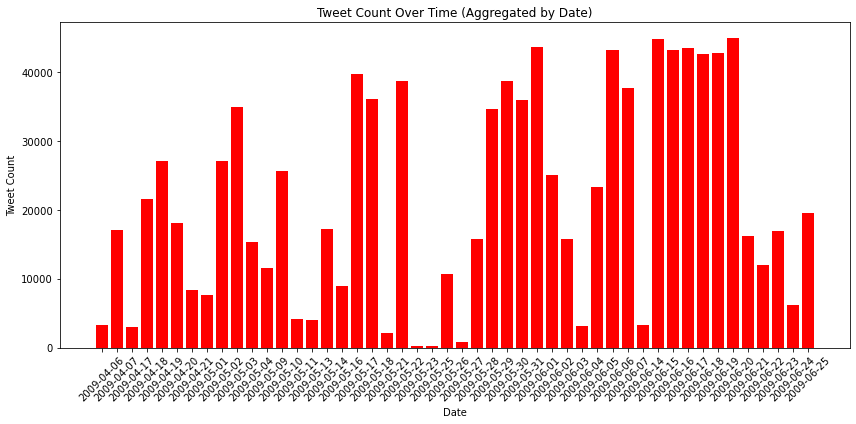

In [41]:
# Plot the tweet count with red bars
plt.figure(figsize=(12, 6))
plt.bar(dates, tweet_counts, color='red')  # Set color to red
plt.title("Tweet Count Over Time (Aggregated by Date)")
plt.xlabel("Date")
plt.ylabel("Tweet Count")
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.tight_layout()

# Show the plot
plt.show()

In [42]:
from pyspark.sql.functions import col, date_add, datediff
import pyspark.sql.functions as F
from datetime import date, timedelta

# Extract the date part from the 'date' column
cassandraDF = cassandraDF.withColumn("date", col("date").cast("date"))

# Sort the DataFrame by date
cassandraDF = cassandraDF.orderBy("date")

# Calculate the next date using the lead function
cassandraDF = cassandraDF.withColumn("next_date", date_add(col("date"), 1))

# Check if the next date is continuous (no break)
cassandraDF = cassandraDF.withColumn("is_continuous", datediff(col("next_date"), col("date")) == 1)

# Create a window specification to order by date
window_spec = Window.orderBy("date")

# Assign a group identifier to continuous sequences
cassandraDF = cassandraDF.withColumn("group_id", F.sum(col("is_continuous").cast("int")).over(window_spec))

# Filter only the rows with continuous sequences
continuous_dates = cassandraDF.filter(col("is_continuous")).select("date").distinct()

# Sort the list in ascending order
continuous_dates = continuous_dates.orderBy("date")

# Get the first and last dates in the DataFrame
first_date = continuous_dates.first().date
last_date = continuous_dates.orderBy(col("date").desc()).first().date

# Print the first and last dates
print("First Date:", first_date)
print("Last Date:", last_date)

# Define the start and end date for the range
start_date = first_date
end_date = last_date

# Generate a list of all dates in the range
date_range = [start_date + timedelta(days=x) for x in range((end_date - start_date).days + 1)]

# Convert the list of continuous dates to a Python list
continuous_dates_list = [row.date for row in continuous_dates.collect()]

# Find the dates not in the list
missing_dates = [d for d in date_range if d not in continuous_dates_list]

# Print the missing dates
for missing_date in missing_dates:
    print(missing_date)

# Count the missing days
missing_days_count = len(missing_dates)

# Print the missing days count
print("Missing Days Count:", missing_days_count)

First Date: 2009-04-06
Last Date: 2009-06-25


2009-04-08
2009-04-09
2009-04-10
2009-04-11
2009-04-12
2009-04-13
2009-04-14
2009-04-15
2009-04-16
2009-04-22
2009-04-23
2009-04-24
2009-04-25
2009-04-26
2009-04-27
2009-04-28
2009-04-29
2009-04-30
2009-05-05
2009-05-06
2009-05-07
2009-05-08
2009-05-12
2009-05-15
2009-05-19
2009-05-20
2009-05-24
2009-06-08
2009-06-09
2009-06-10
2009-06-11
2009-06-12
2009-06-13
Missing Days Count: 33


### Outliers

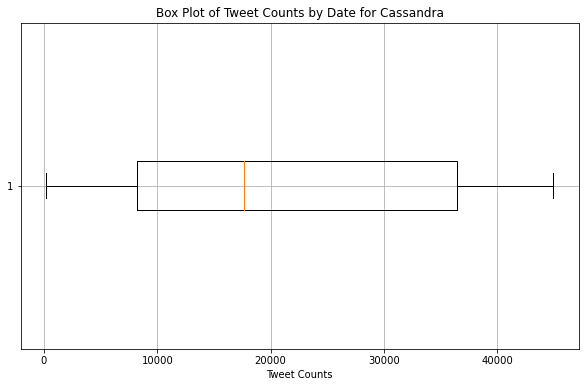

In [43]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import to_date, count

# Group the data by the date without the hour
cassandraDF = cassandraDF.withColumn("date_without_hour", to_date(cassandraDF["date"]))
cassandraDF_counts = cassandraDF.groupBy("date_without_hour").agg(count("*").alias("tweet_count"))

# Sort the data by date without hour
cassandraDF_counts = cassandraDF_counts.orderBy("date_without_hour")

# Collect the data to the driver
cassandraDF_counts = cassandraDF_counts.collect()

# Extract tweet counts for plotting
tweet_counts = [row.tweet_count for row in cassandraDF_counts]

# Create a box plot with outliers marked
plt.figure(figsize=(10, 6))
plt.boxplot(tweet_counts, vert=False, flierprops=dict(marker='o', markerfacecolor='red', markersize=8))
plt.title("Box Plot of Tweet Counts by Date for Cassandra")
plt.xlabel("Tweet Counts")
plt.grid(True)

plt.show()

In [44]:
# Display the potential outliers (if any) and print them
outliers = []

q1 = date_counts[0].tweet_count
q3 = date_counts[-1].tweet_count
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

for idx, tweet_count in enumerate(tweet_counts):
    if tweet_count < lower_bound or tweet_count > upper_bound:
        outliers.append((date_counts[idx].date_without_hour, tweet_count))

# Print the potential outliers
print("Potential Outliers:")
for date, count in outliers:
    print(f"Date: {date}, Tweet Count: {count}")

Potential Outliers:
Date: 2009-06-15, Tweet Count: 44818
Date: 2009-06-20, Tweet Count: 44946


### Comparison between Hive and Cassandra datasets

In [45]:
# Get the row count for 'data'
hive_row_count = data.count()

# Get the row count for 'cassandraDF'
cassandra_row_count = cassandraDF.count()

# Calculate the total difference
total_difference = hive_row_count - cassandra_row_count

# Print the row counts and total difference
print("Hive Database Row Count:", hive_row_count)
print("Cassandra Database Row Count:", cassandra_row_count)
print("Total Difference:", total_difference)

Hive Database Row Count: 1599999
Cassandra Database Row Count: 1036130
Total Difference: 563869


In [46]:
from pyspark.sql.functions import to_date, count
from pyspark.sql.window import Window

# Group the 'data' by the date without the hour
data = data.withColumn("date_without_hour", to_date(data["date"]))
data_date_counts = data.groupBy("date_without_hour").agg(count("*").alias("data_tweet_count"))

# Group 'cassandraDF' by the date without the hour
cassandraDF = cassandraDF.withColumn("date_without_hour", to_date(cassandraDF["date"]))
cassandra_date_counts = cassandraDF.groupBy("date_without_hour").agg(count("*").alias("cassandra_tweet_count"))

# Sort the data by date without hour
data_date_counts = data_date_counts.orderBy("date_without_hour")
cassandra_date_counts = cassandra_date_counts.orderBy("date_without_hour")

# Collect the data to the driver
data_date_counts = data_date_counts.collect()
cassandra_date_counts = cassandra_date_counts.collect()

# Extract tweet counts and calculate the total difference per day
data_tweet_counts = [row.data_tweet_count for row in data_date_counts]
cassandra_tweet_counts = [row.cassandra_tweet_count for row in cassandra_date_counts]
difference_per_day = [data - cassandra for data, cassandra in zip(data_tweet_counts, cassandra_tweet_counts)]

# Print the tweet counts for both datasets and the total difference beside
for date, data_count, cassandra_count, diff in zip(data_date_counts, data_tweet_counts, cassandra_tweet_counts, difference_per_day):
    print(f"Date: {date.date_without_hour}, Hive Count: {data_count}, Cassandra Count: {cassandra_count}, Total Difference: {diff}")

Date: 2009-04-06, Hive Count: 3359, Cassandra Count: 3321, Total Difference: 38
Date: 2009-04-07, Hive Count: 17311, Cassandra Count: 17119, Total Difference: 192
Date: 2009-04-17, Hive Count: 3084, Cassandra Count: 3047, Total Difference: 37
Date: 2009-04-18, Hive Count: 21754, Cassandra Count: 21506, Total Difference: 248
Date: 2009-04-19, Hive Count: 27469, Cassandra Count: 27136, Total Difference: 333
Date: 2009-04-20, Hive Count: 18460, Cassandra Count: 18128, Total Difference: 332
Date: 2009-04-21, Hive Count: 8587, Cassandra Count: 8423, Total Difference: 164
Date: 2009-05-01, Hive Count: 7716, Cassandra Count: 7568, Total Difference: 148
Date: 2009-05-02, Hive Count: 27434, Cassandra Count: 27125, Total Difference: 309
Date: 2009-05-03, Hive Count: 35333, Cassandra Count: 34902, Total Difference: 431
Date: 2009-05-04, Hive Count: 15481, Cassandra Count: 15293, Total Difference: 188
Date: 2009-05-09, Hive Count: 11739, Cassandra Count: 11588, Total Difference: 151
Date: 2009-05-

### Normal Distribution Comparison

Shapiro-Wilk Test Results:
Data dataset: p-value = 7.3197452366002835e-06, Not Normally Distributed
CassandraDF dataset: p-value = 0.0011485544964671135, Not Normally Distributed


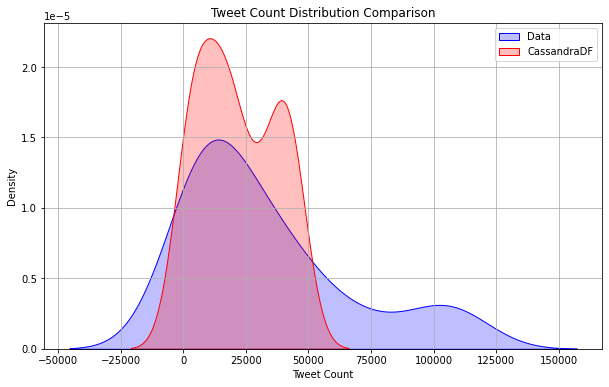

In [47]:
import seaborn as sns
from scipy.stats import shapiro
import matplotlib.pyplot as plt

# Extract the tweet counts for both datasets
data_tweet_counts = [row.tweet_count for row in date_counts]
cassandraDF_tweet_counts = [row.tweet_count for row in cassandraDF_counts]

# Create a KDE plot to compare the distributions
plt.figure(figsize=(10, 6))
sns.kdeplot(data_tweet_counts, label='Data', color='blue', shade=True)
sns.kdeplot(cassandraDF_tweet_counts, label='CassandraDF', color='red', shade=True)
plt.title("Tweet Count Distribution Comparison")
plt.xlabel("Tweet Count")
plt.ylabel("Density")
plt.legend()
plt.grid(True)

# Perform the Shapiro-Wilk test to check for normal distribution
data_sw_stat, data_sw_p_value = shapiro(data_tweet_counts)
cassandraDF_sw_stat, cassandraDF_sw_p_value = shapiro(cassandraDF_tweet_counts)

# Print the results of the Shapiro-Wilk test
print("Shapiro-Wilk Test Results:")
print(f"Data dataset: p-value = {data_sw_p_value}, {'Normally Distributed' if data_sw_p_value > 0.05 else 'Not Normally Distributed'}")
print(f"CassandraDF dataset: p-value = {cassandraDF_sw_p_value}, {'Normally Distributed' if cassandraDF_sw_p_value > 0.05 else 'Not Normally Distributed'}")

# Show the plot
plt.show()

#### Note: A Comparison of Datasets between Hive and Cassandra.

- While these NoSQL datasets were generated from the original data provided as a study tool, a noticeable difference can be observed in the total number of rows between them:
    - Hive Database Row Count: 1599999
    - Cassandra Database Row Count: 1036130
    - Total Difference: 563869.
- The Hive database was created through HDFS, and was built using the original file, employing Spark commands in the Jupyter notebook. 
- In contrast, the Cassandra database was created within the Cassandra prompt using commands related to tables, keyspaces, and the COPY FROM function, where the original file was utilized.

In [48]:
# Check the DataFrame
data.show(5)

2023-11-08 12:44:11,358 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
2023-11-08 12:44:11,372 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
2023-11-08 12:44:38,034 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
2023-11-08 12:44:42,878 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+----------+--------------------+--------------------+-----------------+----------+-------------+--------+
|      date|               tweet|               label|date_without_hour| next_date|is_continuous|group_id|
+----------+--------------------+--------------------+-----------------+----------+-------------+--------+
|2009-04-06|is upset that he ...|is upset that he ...|       2009-04-06|2009-04-07|         true|    3359|
|2009-04-06|@Kenichan I dived...|@Kenichan I dived...|       2009-04-06|2009-04-07|         true|    3359|
|2009-04-06|my whole body fee...|my whole body fee...|       2009-04-06|2009-04-07|         true|    3359|
|2009-04-06|@nationwideclass ...|@nationwideclass ...|       2009-04-06|2009-04-07|         true|    3359|
|2009-04-06|@Kwesidei not the...|@Kwesidei not the...|       2009-04-06|2009-04-07|         true|    3359|
+----------+--------------------+--------------------+-----------------+----------+-------------+--------+
only showing top 5 rows



In [49]:
from pyspark.sql.functions import concat, lit

# Initialize a Spark session
spark = SparkSession.builder.appName("TweetPreprocessing").getOrCreate()

# Recall the HIVE DataFame 
# First, create a new column 'tweet' with the same data as 'label'
data = data.withColumn("tweet", data["label"])

# Drop the specified columns
columns_to_drop = ["date_without_hour", "next_date", "is_continuous", "group_id"]
data = data.drop(*columns_to_drop)

# Now, remove the 'label' column and put the text in quotation marks
data = data.drop("label")
data = data.withColumn("tweet", concat(lit('"'), data["tweet"], lit('"')))

# Show the data
data.show()

# Save the DataFrame as TweetPreProcessing in a suitable format like Parquet
data.write.mode("overwrite").save("TweetPreProcessing", format="parquet")

# Stop the Spark session
spark.stop()

+----------+--------------------+
|      date|               tweet|
+----------+--------------------+
|2009-04-06|"is upset that he...|
|2009-04-06|"@Kenichan I dive...|
|2009-04-06|"my whole body fe...|
|2009-04-06|"@nationwideclass...|
|2009-04-06|"@Kwesidei not th...|
|2009-04-06|       "Need a hug "|
|2009-04-06|"@LOLTrish hey  l...|
|2009-04-06|"@Tatiana_K nope ...|
|2009-04-06|"@twittera que me...|
|2009-04-06|"spring break in ...|
|2009-04-06|"I just re-pierce...|
|2009-04-06|"@caregiving I co...|
|2009-04-06|"@octolinz16 It i...|
|2009-04-06|"@smarrison i wou...|
|2009-04-06|"@iamjazzyfizzle ...|
|2009-04-06|"Hollis' death sc...|
|2009-04-06|"about to file ta...|
|2009-04-06|"@LettyA ahh ive ...|
|2009-04-06|"@FakerPattyPattz...|
|2009-04-06|"@alydesigns i wa...|
+----------+--------------------+
only showing top 20 rows



### Storing the resulting HIVE DataFrame to HBase database

In [53]:
# Store resulting preprocessing Hive dataset to HBase database
def save():
    # Create a Spark session
    spark = SparkSession.builder \
        .appName('HBaseIntegration') \
        .getOrCreate()

    # Load data from Hive into a DataFrame
    data = spark.table("ca2_projecttweets")

    # Define HBase configuration
    hbase_host = "localhost"
    hbase_port = "2181"  # Default ZooKeeper client port
    hbaseConfig = {
        "hbase.zookeeper.quorum": f"{hbase_host}:{hbase_port}",
        "hbase.mapreduce.inputtable": "Resulting_TweetDF"  # Choose a table name
    }

    # Save the Hive dataset to HBase
    data.write \
        .options(**hbaseConfig) \
        .format("org.apache.hadoop.hbase.spark") \
        .option("ResultingData", "ProjectTweets")  # Specify the HBase table name
        .option("hbase.columns.mapping", "CF:tweet,CF:date")  # Define column mapping

    data.write.save()  # Save the data to HBase

    # Stop the Spark session when done
    spark.stop()

# Call the save() function to execute the code
save()

IndentationError: unexpected indent (277125381.py, line 24)

### Storing the resulting HIVE DataFrame to Cassandra database

In [56]:
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder \
    .appName('HiveToCassandra') \
    .config("spark.cassandra.connection.host", "127.0.0.1") \
    .config("spark.cassandra.output.consistency.level", "ONE") \
    .enableHiveSupport()  # Enable Hive support
    .getOrCreate()

# Load data from Hive
data = spark.sql("SELECT tweet, date FROM ca2_projecttweets")

# Save 'data' to Cassandra
data.write \
    .format("org.apache.spark.sql.cassandra") \
    .options(keyspace="ca2_sem2", table="Resulting_TweetDF") \
    .mode("append")  # New data is added to the existing table or dataset. If the table or dataset does not exist, it will be created.
    .save()

IndentationError: unexpected indent (265384168.py, line 9)

In [ ]:
# compare the two 2 databases (hbase and cassandra) using ycsb 
# and call (read)sentiment analysis from one of the databases.

### Sentiment Analysis on ProjectTweets

In [ ]:
# !pip install pandas langdetect

In [ ]:
# Import the necessary libraries
from pyspark.sql import SparkSession
import pandas as pd
from langdetect import detect

# Initialize a Spark session
spark = SparkSession.builder.appName("SentimentAnalysis").getOrCreate()

# Load dataset into a Spark DataFrame
spark_df = spark.read.csv("hdfs://localhost:9000/user/hduser/CA2/ProjectTweets.csv", header=True, inferSchema=True)

# Check if the data was loaded successfully
if spark_df is not None:
    # Define column names
    new_column_names = ["number", "id_tweet", "date", "query", "user_id", "tweet"]

    # Rename the columns using the alias method
    for i in range(len(new_column_names)):
        spark_df = spark_df.withColumnRenamed(spark_df.columns[i], new_column_names[i])

# Convert the Spark DataFrame to a Pandas DataFrame
pandas_df = spark_df.toPandas()

# Display the first 5 rows of the Pandas DataFrame
pandas_df.head(5)

In [ ]:
# Check the shape of the Pandas DataFrame
pandas_df.shape

In [ ]:
import re

# Remove duplicates (if necessary)
pandas_df.drop_duplicates(inplace=True)

# Preprocess text data
# Lowercase the text
pandas_df['cleaned_tweet'] = pandas_df['tweet'].str.lower()

# Remove special characters and perform tokenization 
pandas_df['cleaned_tweet'] = pandas_df['cleaned_tweet'].apply(lambda text: re.sub(r'[^a-zA-Z0-9\s]', '', text))
pandas_df['tokenized_tweet'] = pandas_df['cleaned_tweet'].str.split()

# Display the first few rows of the cleaned and tokenized data
print(pandas_df[['tweet', 'tokenized_tweet']].head(5))

# Define a function to check if the tokenized text is in English
def is_english(tokens):
    try:
        for token in tokens:
            language = detect(token)
            if language != 'en':
                return False
        return True
    except:
        return False

# Calculate the number of rows in English and not in English
english_count = 0
non_english_count = 0

for _, row in pandas_df.iterrows():
    tokens = row['tokenized_tweet']
    if is_english(tokens):
        english_count += 1
    else:
        non_english_count += 1

# Print the results
print(f"Number of rows in English: {english_count}")
print(f"Number of rows not in English: {non_english_count}")

# Define a function to check if the tokenized text is in English
def is_english(tokens):
    try:
        for token in tokens:
            language = detect(token)
            if language != 'en':
                return False
        return True
    except:
        return False

# Apply the language detection function to the "tokenized_text" column and create a new column "is_english"
pandas_df['is_english'] = pandas_df['tokenized_tweet'].apply(is_english)

# Calculate the number of rows in English and not in English
english_counts = pandas_df['is_english'].value_counts()
num_english_rows = english_counts.get(True, 0)
num_non_english_rows = english_counts.get(False, 0)

# Print the results
print(f"Number of rows in English: {num_english_rows}")
print(f"Number of rows not in English: {num_non_english_rows}")

### References:

• https://github.com/apache/hive

• https://cassandra.apache.org/doc/latest/cassandra/cql/ddl.html

• Cassandra: The Definitive Guide, (Revised) Third Edition, 3rd Edition, Jeff Carpenter, Eben Hewitt,
O'Reilly Media, Inc., January 2022.